In [1]:
%cd ..

c:\Users\justi\Coding\MA-thesis


In [2]:
from enum import Enum
import librosa
import numpy as np
from evoaudio.fitness import fitness_cached
from evoaudio.individual import BaseIndividual
from evoaudio.population import Population
from evoaudio.target import Target
from evoaudio.sample_library import SampleLibrary
from parsing.arff_parsing import parse_arff

In [3]:
sample_lib = SampleLibrary()

Loading samples:   0%|          | 0/6826 [00:00<?, ?it/s]

In [4]:
pop = Population.from_file("./experiments/tiny_aam/300_1_3000_0.05_5_10_1_20_0.9954_15_20_1sec_repeat/0/0001.pkl", expand=True, sample_lib=sample_lib)
annotations = parse_arff("./audio/tiny_aam/annotations/0001_onsets.arff")
target_mix, target_sr = librosa.load("./audio/tiny_aam/audio-mixes-mp3/0001_mix.mp3")
onsets = [int(round(float(onset_time) * target_sr)) for onset_time in annotations.keys()]
target = Target(target_mix, onsets)

FileNotFoundError: [Errno 2] No such file or directory: './experiments/tiny_aam/300_1_3000_0.05_5_10_1_20_0.9954_15_20_1sec_repeat/0/0001.pkl'

In [11]:
def get_sample_retry(instrument, pitch):
    sample = None
    while sample is None:
        try:
            sample = sample_lib.get_sample(
                instrument=instrument, 
                style=sample_lib.get_random_style_for_instrument(instrument), 
                pitch=pitch
            )
        except:
            continue
    return sample

def annotation_to_individual(annotation):
    samples = []
    for tup in annotation:
        instrument = tup[0]
        pitch = int(tup[1].replace("+", ""))
        samples.append(get_sample_retry(instrument, pitch))
    ind = BaseIndividual()
    ind.samples = samples
    return ind

class class_mode(Enum):
    INSTRUMENTS = 0
    PITCHES = 1
    COMBINED = 2

def extract_instruments(individual:BaseIndividual):
    seen_instruments = []
    for sample in individual.samples:
        if sample.instrument not in seen_instruments:
            seen_instruments.append(sample.instrument)
    return seen_instruments

def extract_pitches(individual:BaseIndividual):
    seen_pitches = []
    for sample in individual.samples:
        if sample.pitch not in seen_pitches:
            seen_pitches.append(sample.pitch)
    return seen_pitches

def extract_samples(individual:BaseIndividual):
    seen_samples = []
    for sample in individual.samples:
        if (sample.instrument, sample.pitch) not in seen_samples:
            seen_samples.append((sample.instrument, sample.pitch))
    return seen_samples

def jaccard_error(population:Population, annotations:dict, mode:class_mode):
    """Iteratively calculates the jaccard error for each onset, then returns the mean.

    Parameters
    ----------
    population : Population
        candidate population.
    annotations : dict
        extracted annotations in style {onset: [(instrument1, pitch1), (instrument2, pitch2), ...]}
    mode : class_mode
        whether to calculate the error for instrument, pitch or combined approximation

    Returns
    -------
    float
        mean jaccard error across all onsets.
    """
    time_onsets = list(annotations.keys())
    jaccard_errors_per_onset = []
    for i, onset in enumerate(population.archive):
        individual = population.archive[onset].individual
        time_onset = time_onsets[i]
        match mode:
            case class_mode.INSTRUMENTS:
                extracted_features = extract_instruments(individual)
                annotated_features = [annotation[0] for annotation in annotations[time_onset]]
            case class_mode.PITCHES:
                extracted_features = extract_pitches(individual)
                annotated_features = [annotation[1] for annotation in annotations[time_onset]]
            case class_mode.COMBINED:
                extracted_features = extract_samples(individual)
                annotated_features = annotations[time_onset]
        intersection = [instrument for instrument in extracted_features if instrument in annotated_features]
        union = list(set(extracted_features) | set(annotated_features))
        false_positives = set(extracted_features).symmetric_difference(intersection)
        false_negatives = set(annotated_features).symmetric_difference(intersection)
        jaccard_errors_per_onset.append((len(false_positives) + len(false_negatives)) / len(union))
    return jaccard_errors_per_onset

In [ ]:
true_fitnesses = []
record_fitnesses = []
for i, time in enumerate(list(annotations.keys())[:-1]):
    onset = list(pop.archive.keys())[i]
    record = pop.archive[onset]
    annotation = annotations[time]
    annotated_ind = annotation_to_individual(annotation)
    true_fitness = (fitness_cached(annotated_ind, target.abs_stft_per_snippet[onset]))
    annotated_ind.fitness = true_fitness
    true_fitnesses.append(true_fitness)
    record_fitnesses.append(record.fitness)
distances = np.array(true_fitnesses) - np.array(record_fitnesses)
bad_distances = [distance for distance in distances if distance > 0]
print(len(bad_distances) / len(distances))

0.9103260869565217


In [ ]:
instrument_errors = jaccard_error(pop, annotations, class_mode.INSTRUMENTS)
pitch_errors = jaccard_error(pop, annotations, class_mode.PITCHES)
combined_errors = jaccard_error(pop, annotations, class_mode.COMBINED)
print(instrument_errors)

[1.0, 0.8, 0.8, 0.6666666666666666, 0.8, 0.8, 0.8571428571428571, 0.8571428571428571, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 1.0, 0.8, 0.8, 0.8571428571428571, 1.0, 0.8, 0.8571428571428571, 0.8571428571428571, 0.8, 0.8333333333333334, 1.0, 0.8333333333333334, 1.0, 0.8, 0.8, 0.8, 0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 0.8571428571428571, 0.8, 0.8571428571428571, 1.0, 0.8, 0.8, 0.8, 0.8, 1.0, 0.6666666666666666, 0.6666666666666666, 1.0, 0.8333333333333334, 0.8, 0.8, 0.6666666666666666, 0.8, 0.8, 0.8571428571428571, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8, 0.8, 0.8571428571428571, 1.0, 0.8, 1.0, 0.8571428571428571, 0.8, 0.8, 1.0, 0.8333333333333334, 1.0, 0.8, 0.8, 0.8, 0.8, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 0.8571428571428571, 0.8, 0.8571428571428571, 1.0, 0.8, 0.8, 0.8, 0.8, 0.8, 0.6666666666666666, 0.6666666666666666, 1.0, 1.0, 0.8, 0.8, 0.8, 0.8, 0.8, 1.0, 0.8571428571428571, 1.0, 1.0, 1.0, 0.8571428571428571, 0.8333333333333334, 1.0,

(0.0, 2.0)

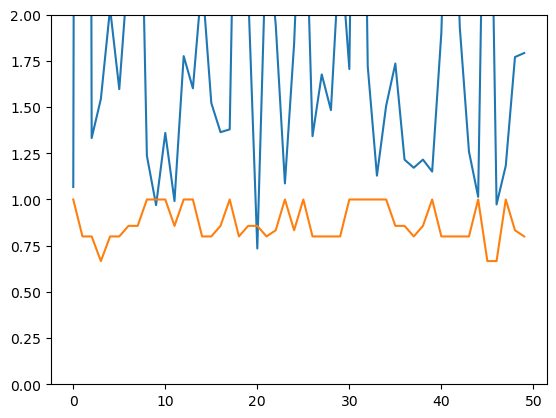

In [ ]:
import matplotlib.pyplot as plt
plt.plot(true_fitnesses[:50])
plt.plot(instrument_errors[:50])
plt.ylim((0, 2))

## Investigating other Fitness Function

In [ ]:
ind = annotation_to_individual(annotations[list(annotations.keys())[0]])
mix = ind.to_mixdown()
mfcc = librosa.feature.mfcc(y=mix, n_mfcc=13)
mfcc_avg = np.mean(mfcc, axis=1)
mfcc_avg.shape

(13,)

In [ ]:
def beta_divergence(beta, x, y):
    def d(beta, x, y):
        if beta == 0:
            return x / y - np.log(x/y) - 1
        elif beta == 1:
            return x * np.log(x/y) + (y - x)
        else:
            return (1 / (beta * (beta - 1))) * (x**beta + (beta - 1) * y**beta - beta * x * y**(beta - 1))
    inner_sum = [d(beta, x[i], y[i]) for i in range(len(x))]
    return np.sum(inner_sum)

def mfcc_fitness(x, y):
    mfcc_x = librosa.feature.mfcc(y=x, n_mfcc=13)
    mfcc_y = librosa.feature.mfcc(y=y, n_mfcc=13)
    return beta_divergence(2, np.mean(mfcc_x, axis=1), np.mean(mfcc_y, axis=1))

In [ ]:
# Repeat above calculations with mfcc
true_fitnesses_mfcc = []
record_fitnesses_mfcc = []
for i, time in enumerate(list(annotations.keys())[:-1]):
    onset = list(pop.archive.keys())[i]
    record = pop.archive[onset]
    annotation = annotations[time]
    annotated_ind = annotation_to_individual(annotation)
    true_fitness_mfcc = (mfcc_fitness(annotated_ind.to_mixdown(), target.y[onset:onsets[i+1]]))
    annotated_ind.fitness = true_fitness_mfcc
    true_fitnesses_mfcc.append(true_fitness_mfcc)
    record_fitnesses_mfcc.append(mfcc_fitness(record.individual.to_mixdown(), target.y[onset:onsets[i+1]]))
distances_mfcc = np.array(true_fitnesses_mfcc) - np.array(record_fitnesses_mfcc)
bad_distances_mfcc = [distance for distance in distances_mfcc if distance > 0]
print(len(bad_distances_mfcc) / len(distances_mfcc))

0.5978260869565217


In [ ]:
print(record_fitnesses_mfcc)

[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,

In [ ]:
print(true_fitnesses_mfcc)

[19445.350924191473, 22677.92713126676, 23736.281517677944, 28020.640296903723, 22782.55000845725, 17195.002139858945, 18838.262745382282, 24014.684040358705, 15296.09057401706, 24492.816744364733, 23270.59022112797, 19089.20728576622, 24520.528280633684, 17201.34609778133, 22076.99813059029, 18664.712941135404, 19960.907701853917, 21143.19658368018, 17602.99274030281, 31318.06063439956, 17783.13848927814, 21662.54540834237, 21350.13553911737, 18816.700666211942, 28187.791681080496, 15128.034190569271, 29555.607896113554, 13701.054041845691, 22264.142725811977, 17493.02189980393, 13362.230273890815, 18727.830387327223, 18778.36377384367, 18658.20630056839, 19527.191900464775, 19631.51321310322, 16245.245193291541, 15639.834306776118, 22579.963520666086, 16262.631417602526, 20724.70345372952, 18222.381564042407, 14215.494381248946, 13136.121667134948, 25815.50915136025, 17876.156378165266, 11277.008897260472, 21717.919948008042, 20994.52010823911, 22090.982148596657, 27139.026667792354,

## Investigating Attacks / Holds

In [24]:
from evoaudio.base_sample import BaseSample
class ModdedIndividual(BaseIndividual):
    def __init__(self, phi:float = 0.1, hold_delay:int = 22050):
        super().__init__(phi)
        self.holds = [False for _ in self.samples] # Bool, if True makes the note a hold
        self.hold_delay = hold_delay
    def add_sample(self, sample:BaseSample, hold:bool):
        self.samples.append(sample)
        self.holds.append(hold)
    def to_mixdown(self) -> np.ndarray:
        ys_holding = []
        for i in range(len(self.samples)):
            if self.holds[i]:
                ys_holding.append(self.samples[i].y[self.hold_delay:])
            else:
                ys_holding.append(self.samples[i].y)
        # Resize by expanding all samples to the same length
        max_length = np.max([len(y) for y in ys_holding])
        ys_equal_length = [np.pad(y, (0, max_length - len(y))) for y in ys_holding]
        return np.sum(ys_equal_length, axis=0)

def annotation_to_modded_individual(annotation, hold_delay):
    ind = ModdedIndividual(hold_delay=hold_delay)
    for tup in annotation:
        instrument = tup[0]
        hold = not "+" in tup[1]
        pitch = int(tup[1].replace("+", ""))
        ind.add_sample(get_sample_retry(instrument, pitch), hold)
    return ind

In [21]:
annotations = parse_arff("./audio/tiny_aam/annotations/0001_onsets.arff")
target_mix, target_sr = librosa.load("./audio/tiny_aam/audio-mixes-mp3/0001_mix.mp3")
onsets = [int(round(float(onset_time) * target_sr)) for onset_time in annotations.keys()]
target = Target(target_mix, onsets)

true_fitnesses_holds = []
for i, time in enumerate(list(annotations.keys())[:-1]):
    annotation = annotations[time]
    annotated_ind = annotation_to_modded_individual(annotation)
    true_fitness = (fitness_cached(annotated_ind, target.abs_stft_per_snippet[target.onsets[i]]))
    annotated_ind.fitness = true_fitness
    true_fitnesses_holds.append(true_fitness)
print(true_fitnesses_holds)

[1.1579446932164634, 1.2798497046493902, 1.6429115853658536, 1.4794818264100609, 1.313826219512195, 1.1927761766387195, 1.0674423589939024, 1.1773454173018292, 1.6971493902439025, 1.2951258812881097, 0.982274795160061, 0.9870692406631097, 1.1229820884146342, 1.262115567835366, 1.5623215987042682, 1.4803646627286586, 4.684930449695122, 1.042157607660061, 2.0505411585365856, 1.5751430306783536, 1.6015646436737805, 2.3734708460365854, 2.4295693597560977, 1.257266220464939, 1.5058960556402439, 1.8126991234756098, 1.1098389862804878, 1.8029563643292683, 1.1452352086509145, 1.0790770293445122, 1.612483565167683, 1.280676924542683, 0.7851395174352134, 1.8983353182164635, 0.8008225157202744, 1.7393017578125, 2.422371855945122, 1.2053806211890243, 1.0470301781631097, 1.1362373761432927, 2.0796936928353658, 1.1342961604420732, 2.5249826124237806, 1.4164693692835366, 0.9284169564596036, 0.9322453791920732, 0.7955238900533537, 0.846989805640244, 3.703465129573171, 1.7531266673018293, 1.22665181974

In [19]:
annotations = parse_arff("./audio/tiny_aam/annotations/0001_onsets.arff")
target_mix, target_sr = librosa.load("./audio/tiny_aam/audio-mixes-mp3/0001_mix.mp3")
onsets = [int(round(float(onset_time) * target_sr)) for onset_time in annotations.keys()]
target = Target(target_mix, onsets)

true_fitnesses = []
for i, time in enumerate(list(annotations.keys())[:-1]):
    annotation = annotations[time]
    annotated_ind = annotation_to_individual(annotation)
    true_fitness = (fitness_cached(annotated_ind, target.abs_stft_per_snippet[target.onsets[i]]))
    annotated_ind.fitness = true_fitness
    true_fitnesses.append(true_fitness)
print(true_fitnesses)

[0.7837099847560975, 1.7481142816310975, 3.638292206554878, 1.2091658727134147, 2.4951488662347563, 1.103178115472561, 1.525942978277439, 1.155810546875, 1.9879789919969513, 1.1702394959984757, 0.8523077839176829, 2.09671875, 0.9915648223132622, 3.849332364710366, 1.3241041825457318, 1.8373788824314023, 1.573189072027439, 1.3648863852896342, 1.8648219559832317, 3.7698113567073173, 1.0622041730182927, 2.470805544969512, 1.751626572027439, 1.1885600466844513, 1.4364646055640244, 1.4793739281631098, 1.629608779535061, 1.6768228372713414, 1.395151486280488, 1.350662276105183, 1.7935020483993902, 5.330717416158537, 0.8083249571265244, 1.0865815548780489, 0.7311672303734756, 6.158089272103658, 1.850612137957317, 1.9909932355182927, 1.059764434070122, 1.0775465653582317, 2.672979706554878, 14.872253239329268, 1.1099561737804877, 1.1572825362042682, 1.5691031107088416, 4.128235518292683, 0.9771140791730183, 7.935982278963414, 2.437122237042683, 2.236018483231707, 2.0078227419969514, 1.54379906

In [22]:
np.mean(true_fitnesses), np.mean(true_fitnesses_holds)

(3.314770325774985, 2.7947297453248234)

Investigate length of hold-delay

In [36]:
def get_fitnesses(delay:int):
    true_fitnesses_holds = []
    for i, time in enumerate(list(annotations.keys())[:-1]):
        annotation = annotations[time]
        annotated_ind = annotation_to_modded_individual(annotation, delay)
        true_fitness = (fitness_cached(annotated_ind, target.abs_stft_per_snippet[target.onsets[i]]))
        annotated_ind.fitness = true_fitness
        true_fitnesses_holds.append(true_fitness)
    return true_fitnesses_holds

test_delays = [22050, 11025, 5512, 5512//2, 0]
results = {}
results_full = {}
for delay in test_delays:
    fitnesses = get_fitnesses(delay)
    results[delay] = np.mean(fitnesses)
    results_full[delay] = fitnesses
print(results)

{22050: 2.914698149275552, 11025: 2.8541209096089406, 5512: 2.7869815445350814, 2756: 2.866718305181218, 0: 3.47862551125843}


In [28]:
pop = Population.from_file("0001.pkl", expand=True, sample_lib=sample_lib)
pop_fitnesses = [record.fitness for record in pop.archive.values()]
np.mean(pop_fitnesses)

0.9821797847754107

In [37]:
old_distances = np.array(true_fitnesses) - np.array(pop_fitnesses[:-1])
new_distances = np.array(results_full[5512]) - np.array(pop_fitnesses[:-1])
np.mean(old_distances), np.mean(new_distances)

(2.3342710174204564, 1.806482236180553)

In [38]:
n_worse_old = len([i for i in range(len(true_fitnesses)) if true_fitnesses[i] > pop_fitnesses[i]])
n_worse_new = len([i for i in range(len(results_full[5512])) if results_full[5512][i] > pop_fitnesses[i]])
n_worse_old, n_worse_new

(330, 304)